# Temperature Forecasting data using last 10 years data

Data only contains date-time stamp and temperature data in Degree C.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd ../gdrive/My Drive/Colab Notebooks/time_series

/gdrive/My Drive/Colab Notebooks/time_series


In [ ]:
import pandas as pd
import os 
import numpy as np 
%matplotlib inline 
from matplotlib import pyplot as plt 
import seaborn as sns 

from statsmodels.tsa import stattools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import statsmodels.api as sm
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('USA_SolarPlant_Temp_2009_2016.csv') # every 10 minutes.
df.head(2)

In [ ]:
df_copy = df.copy()

# retain only temperature
df = df[['T (degC)']]


In [ ]:
df.head(2)

,T (degC)
0,-8.02
1,-8.41


In [ ]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
T (degC),420551.0,9.0,8.0,-23.0,3.0,9.0,15.0,37.0


In [ ]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

In [ ]:
# convert to windowed data sets
ylist = list(df['T'])

n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1

import numpy as np
X_new = np.array(X_new)
y_new = np.array(y_new)

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

In [ ]:
# reshape data into the right format for RNNs
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

### One step LSTM 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 72)                648       
                                                                 
Total params: 968
Trainable params: 968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
7040/7040 [==============================] - 460s 65ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 2/2
7040/7040 [==============================] - 472s 67ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
0.9134286648774849


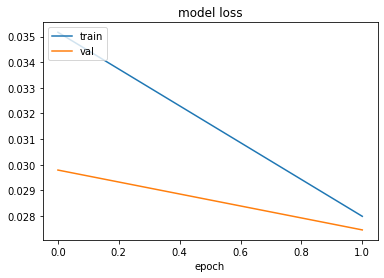

In [ ]:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import keras
import tensorflow as tf

random.seed(42)

batch_size = 32
simple_model = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=2,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### LSTM with 3 layers

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 216, 64)           16896     
                                                                 
 lstm_2 (LSTM)               (None, 216, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 72)                4680      
                                                                 
Total params: 87,624
Trainable params: 87,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
7040/7040 [==============================] - 2476s 351ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 2/2
70

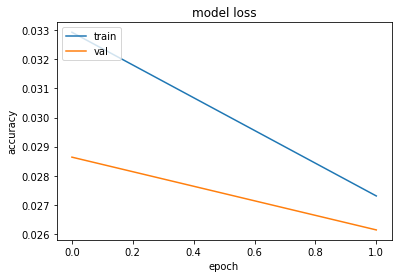

In [ ]:
random.seed(42)

simple_model = Sequential([
   LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=2,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()